In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pickle
import pandas as pd
import os

In [2]:
hbb = pd.read_parquet('parquet/hbb.parquet', engine='fastparquet')
hgg = pd.read_parquet('parquet/hgg.parquet', engine='fastparquet')

In [3]:
qcd = {}
files = os.listdir('parquet')
for i in files:
    if 'to' in i:
        qcd[i.strip('.parquet')] = pd.read_parquet(f'parquet/{i}', engine='fastparquet')

In [4]:
vars = list(qcd['300to470'].keys())

In [5]:
IL = 44.99

In [6]:
xsec = {}
xsec['300to470'] = 6833
xsec['470to600'] = 549.5
xsec['600to800'] = 156.5
xsec['800to1000'] = 26.22
xsec['1000to1400'] = 7.475
xsec['1400to1800'] = 0.6482
xsec['1800to2400'] = 0.08742
xsec['2400to3200'] = 0.005237
xsec['3200toInf'] = 0.0001353

In [7]:
stitched_dict = {}
for j in vars:
    qcd_frac = {}
    for i in qcd:
        qcd_frac[i] = ((xsec[i]*1000)*IL)/len(qcd[i][j])
    qcd_frac['tot'] = sum(qcd_frac.values())
    sval = {}
    for i in qcd:
        sval[i] = qcd_frac[i]/qcd_frac['tot']
    combed = {}
    for i in qcd:
        temp = qcd[i][j]
        combed[i] = temp[np.random.rand(temp.shape[0]) < sval[i]]
    stitched_var = np.concatenate([combed[x] for x in combed])
    stitched_dict[j] = stitched_var

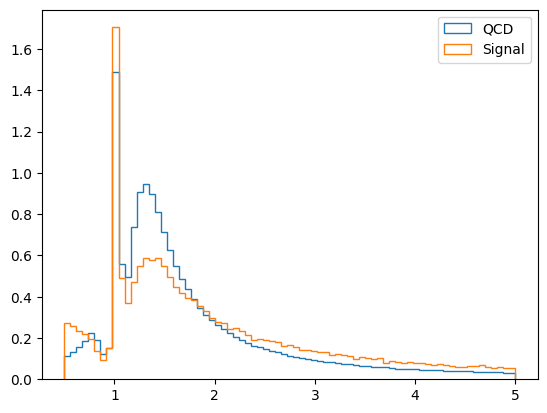

In [8]:
fig, ax = plt.subplots()
plt.hist(stitched_dict['FatJets.color_ring'], range=(.5,5), bins=75, density=True, histtype='step', label='QCD',#weights=21*np.ones_like(tst)
        )
plt.hist(hgg['FatJets.color_ring'], range=(.5,5), bins=75, density=True, histtype='step', label='Signal',#weights=21*np.ones_like(tst)
        )
plt.legend()
#plt.yscale('log')
#plt.xlim(100, 5000)
plt.show()

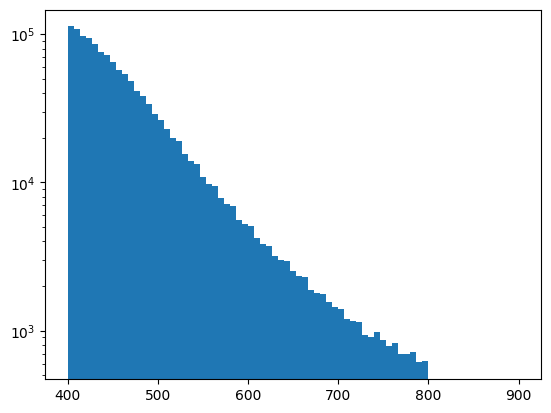

In [9]:
fig, ax = plt.subplots()
plt.hist(stitched_dict['FatJets.pt'], range=(400,900), bins=75, #density=True, #weights=21*np.ones_like(tst)
        )
plt.yscale('log')
#plt.xlim(100, 5000)
plt.show()

In [10]:
hgg = hgg.reset_index(drop=True)

In [11]:
temp = hgg.to_dict('list')

In [12]:
temp_dict = {}
for i in temp:
    temp_dict[i] = np.array(temp[i])

In [13]:
nan_dict = {}
for i in temp_dict:
    nan_mask = ~np.isnan(temp_dict[i])
    nan_dict[i] = nan_mask
nanless = {}
for i in stitched_dict:
    nanless[i] = temp_dict[i][nan_dict[i]]
sizes = []
for i in nanless:
    sizes.append(len(nanless[i]))

losses = [(x - min(sizes)) for x in sizes]
for i in nanless:
    nanless[i] = nanless[i][:min(sizes)]

In [14]:
hgg = pd.DataFrame.from_dict(nanless)

In [15]:
hbb = hbb.reset_index(drop=True)

In [16]:
temp = hbb.to_dict('list')

In [17]:
temp_dict = {}
for i in temp:
    temp_dict[i] = np.array(temp[i])

In [18]:
nan_dict = {}
for i in temp_dict:
    nan_mask = ~np.isnan(temp_dict[i])
    nan_dict[i] = nan_mask
nanless = {}
for i in stitched_dict:
    nanless[i] = temp_dict[i][nan_dict[i]]
sizes = []
for i in nanless:
    sizes.append(len(nanless[i]))

losses = [(x - min(sizes)) for x in sizes]
for i in nanless:
    nanless[i] = nanless[i][:min(sizes)]

In [19]:
hbb = pd.DataFrame.from_dict(nanless)

In [20]:
nan_dict = {}
for i in stitched_dict:
    nan_mask = ~np.isnan(stitched_dict[i])
    nan_dict[i] = nan_mask
nanless = {}
for i in stitched_dict:
    nanless[i] = stitched_dict[i][nan_dict[i]]
sizes = []
for i in nanless:
    sizes.append(len(nanless[i]))

losses = [(x - min(sizes)) for x in sizes]
for i in nanless:
    nanless[i] = nanless[i][:min(sizes)]

In [21]:
qcd = pd.DataFrame.from_dict(nanless)

In [22]:
hgg.to_parquet('parquet/combed/hgg.parquet')
hbb.to_parquet('parquet/combed/hbb.parquet')
qcd.to_parquet('parquet/combed/qcd.parquet')